Let us now implement this with a simple example and the RK4 solver in PyTorch.

/var/folders/h9/96x2b9pn2_v_xfb0gsxn97mw0000gn/T/ipykernel_63125/3707416276.py:10: RuntimeWarning: divide by zero encountered in log
  return 1/2*np.sin(4*np.pi*t) * np.log(t)


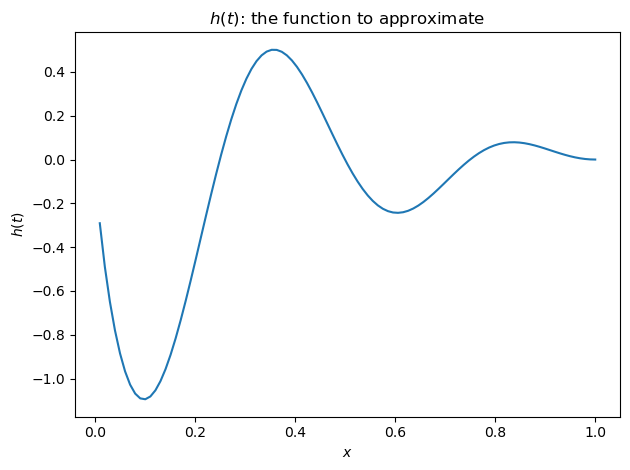

In [5]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import SGD
import matplotlib.pyplot as plt
import torch.nn.functional as F
from jaxtyping import Float


def h(t: Float):
    return 1 / 2 * np.sin(4 * np.pi * t) * np.log(t)


T = [0, 1]
t = torch.linspace(*T, 100)
h_t = [h(t) for t in t]

fig, ax = plt.subplots()
ax.plot(t, h_t)
ax.set_title(r"$h(t)$: the function to approximate")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$h(t)$")
fig.tight_layout()

In [ ]:
# [b, 2] -> [b, 1]
dummy = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)


# ht: [b 1], t: [b 1] - [b 1]
def f(ht, t):
    return dummy(t)
    # return dummy(torch.cat([ht, t], dim=-1))


# ht: [b 1], t: [b 1] -> [b 1]
def rk4_solver(ht, f, t, d):
    k1 = f(ht, t)
    k2 = f(ht + d * k1 / 2, t + d / 2)
    k3 = f(ht + d * k2 / 2, t + d / 2)
    k4 = f(ht + d * k3, t + d)
    return ht + d / 6 * (k1 + 2 * k2 + 2 * k3 + k4)


# ht: [b 1], t: [b 1] -> [b 1]
def euler_solver(ht, f, t, d):
    return ht + d * f(ht, t)


def sample(lower, upper, d):
    t1 = torch.rand(1) * (upper - lower) + lower
    t2 = t1 + d
    ht1, ht2 = h(t1), h(t2)
    return (ht1, t1), (ht2, t2)


def sample_batch(num_samples, lower, upper, d):
    ht1, ht2 = [], []
    t1, t2 = [], []
    for _ in range(num_samples):
        (ht_1, t_1), (ht_2, t_2) = sample(lower, upper, d)
        ht1.append(ht_1)
        ht2.append(ht_2)
        t1.append(t_1)
        t2.append(t_2)
    return (
        torch.stack(ht1, dim=0),
        torch.stack(ht2, dim=0),
        torch.stack(t1, dim=0),
        torch.stack(t2, dim=0),
    )


def calc_loss(solver, f, t1, d, ht1, ht2):
    h_pred = solver(ht1, f, t1, d)
    return F.mse_loss(h_pred, ht2)


def run_inference(solver, f, t_start, t_end, h_start, d):
    h = []
    for i in np.arange(t_start, t_end, d):
        h_start = solver(h_start, f, t_start + i * d, d)
        h.append(h_start)
    return torch.stack(h, dim=0)


lr = 0.00001
d = 0.01
batch_size = 5000
epochs = 100
optim = SGD(dummy.parameters(), lr=lr)
losses = []
for i in range(100):
    ht1, ht2, t1, t2 = sample_batch(batch_size, *T, d)
    loss = calc_loss(euler_solver, f, t1, d, ht1, ht2)
    optim.zero_grad()
    loss.backward()
    optim.step()
    if i % 100 == 0:
        print(loss.item())
    losses.append(loss.item())

result = run_inference(
    rk4_solver, f, torch.tensor([0.0]), torch.tensor([1.0]), torch.tensor([0.0615]), d
)